# SEP 769- Deep Learning Project- Optimizing Energy Usage in Buildings Using IoT Data and Deep Learning Algorithms
> Hongqing Cao 400053625  
Sushant Shailesh Panchal 400614293  
Yanyi He 400651032  
Yash Parab 400611922

## Introduction
This project aims to develop a machine learning-based system to optimize energy usage in buildings using data from IoT sensors. The goal is to reduce energy consumption and costs while maintaining occupant comfort and health. The project involves preprocessing data from IoT sensors, developing a deep learning model to optimize energy usage, and testing the model on new data to evaluate its effectiveness.

The dataset [**Individual Household Electric Power Consumption dataset**](https://archive.ics.uci.edu/dataset/235) is retrived from UCI Machine Learning Repository, which contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

### Objectives
- Compare two different models over a subset of dataset, find the better performed model. 
- Tune, train, and evaluate the selected model, use this model to forecast future power consumption. 
- Visualize the predicted vs actual load, identify peak/vally power load time frames to suggest grid operation. 


### Dataset
- **Source**: UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/235).
- **Information**: This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). 

- **Features**: 
    - `date: dd/mm/yyyy`
    - `time: hh:mm:ss`
    - `global_active_power: float` Total household active power usage in kilowatts (kW)
    - `reactive_power: float` Power not used for work, in KW
    - `voltage: float` Voltage across the circuit, in V
    - `global_intensity: float` Current drawn, in A
    - `sub_metering_1: float` Energy drawn for kitchen, in Wh
    - `sub_metering_2: float` Energy drawn for laundry, in Wh
    - `sub_metering_3: float` Energy drawn for water heater and AC, in Wh
-
- **Note**:  
`global_active_power * 1000 / 60- sub_metering_1- sub_metering_2- sub_metering_3`  
represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
-
- **Missing Data**: The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing (willed with `?`). 

### References
- Marino et al. (2016), *Building Energy Load Forecasting using Deep Neural Networks*. -
- Bonetto & Rossi (2017), *Machine Learning Approaches to Energy Consumption Forecasting in Households*. -
- Gasparin et al. (2019), *Deep Learning for Time Series Forecasting: The Electric Load Case*. 

### Essential Notes
- **Hardware**: The code in notebook in designed to best perform with CUDA GPUs, targeting RTX 4070. 
-
- **Environment**: Use `Python 3.11.7`, `NVIDIA-SMI 575.64.04`, `Driver Version: 577.00`, `CUDA Version: 12.9`. 

## 0. Environment Setup
### Libaries Imported
`numpy 2.1.3`  
`matplotlib 3.10.3`  
`pandas 2.3.1`  
`tensorflow 2.19.0`  
`scikit-learn 1.7.1`  
`keras 3.10.0`  
`tensorboard 2.19.0`  
`seaborn 0.13.2`  

### GPU Config
set `set_memory_growth`, `mixed_precision`

### Utility Functions
``

In [1]:
### Libaries Imported
from os import path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from keras import Sequential, layers, Model
from keras import backend as K
from keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import mixed_precision
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc

%load_ext tensorboard

np.random.seed(42)

2025-07-31 02:19:49.052386: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 02:19:49.111594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753942789.150359 1121827 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753942789.165219 1121827 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753942789.207624 1121827 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
### GPU Config
# use set_memory_growth to aallocate VRAM

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# use mixed_precision to accelrate GPU speed

mixed_precision.set_global_policy('mixed_float16')

In [3]:
### Global Variables
DATA_DIR = "data"
RAW_DIR = DATA_DIR+"/raw"
TRAIN_DIR = DATA_DIR+"/train"
TEST_DIR = DATA_DIR+"/test"

MODEL_DIR = "model"

LOG_DIR = "log"
HPARAM_DIR = LOG_DIR+"/hparam"

In [165]:
### Utility functions

def delete_model(modelname, historyname):
    '''function for delete model, history and free vram'''
    global_vars = globals()
    if modelname in globals():
        del global_vars[modelname]
    if historyname in globals():
        del global_vars[historyname]
    gc.collect()
    K.clear_session()

def check_point(model_name, monitor = 'val_loss', save_best_only = True, hparam = False):
    
    model_dir = MODEL_DIR + '/' + model_name + '.keras'
    if hparam:
        model_dir = 'hparam/' + model_dir
    return ModelCheckpoint(
        model_dir,
        monitor=monitor,
        save_best_only=save_best_only
    )

def early_stop(patience, monitor='val_loss',restore_best_weights=True):
    return EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=restore_best_weights
    )

def inspect_data(df, name):
    '''print summary data of a given dataframe, with
    count
    mean
    std
    min
    25%
    50%
    75%
    max
    dtype
    '''
    print(f"\n{name} summary:")
    print(df.describe())
    print(df.isnull().sum())

def plot_time_series(df, column, start=None, end=None, title=None):
    '''plot the raw time series data from time to end with corresponding column

    column =  global_active_power, sub_metering_other, sub_metering_1/2/3'''
    df_subset = df[start:end] if start or end else df
    df_subset[column].plot(figsize=(12, 4), title=title or column)

def plot_loss(history, maxy=None):
    '''Loss during training'''
    loss = history['loss']
    test_loss = history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, label = 'train loss')
    plt.plot(epochs, test_loss, label = 'val loss')
    if maxy:
        plt.ylim(0, maxy)
    plt.legend()
    plt.title('Loss')
    plt.grid()
    plt.figure()

def plot_forecast(y_true, y_pred, title="Forecast vs Actual"):
    '''plot forecast vs actual lines'''
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Forecast")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_average_forecast(y_true, y_pred , title="Averaged Forecast vs Ground Truth"):
    """
    Visualize average forecasts vs truth.
    """
    y_true = y_true.reshape(y_true.shape[0], 24)
    y_pred = y_pred.reshape(y_pred.shape[0], 24)
    num_windows, forecast_horizon = y_pred.shape
    total_len = num_windows + forecast_horizon- 1

    avg_preds = np.zeros(total_len)
    counts = np.zeros(total_len)

    # Average overlapping predictions
    for i in range(num_windows):
        for j in range(forecast_horizon):
            t = i + j
            avg_preds[t] += y_pred[i, j]
            counts[t] += 1

    # Prevent division by zero
    counts[counts == 0] = 1
    avg_preds /= counts

    # Flatten ground truth
    y_true_flat = y_true.flatten()
    y_aligned = y_true_flat[:total_len]

    plt.figure(figsize=(12, 4))
    plt.plot(y_aligned, label="True", alpha=0.8)
    plt.plot(avg_preds, label="Predicted (avg)", alpha=0.8)
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Target Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 1. Data Preprocessing

### Load Data
- Load raw dataset
- Convert data type

### Resample Data
Resample data to 1-hr

### Handle Missing Data
Reconstruct misssing data with linear interpolation

### Save Raw Data
Save to `data/raw`

### Feature Engineering
- `season_spring: binary` one-hot coded season transformed from `date`
- `season_summer: binary` one-hot coded season transformed from `date`
- `season_autumn: binary` one-hot coded season transformed from `date`
- `season_winter: binary` one-hot coded season transformed from `date`
- `day_of_week: int` categorical in `range(7)`, 0 Sunday, 1 Monday, 6 Saturday
- `hour_sin, hour_cos: float` hour in transfromed from `time` in cyclical encoding, range [-1, 1]
- `global_active_power: float` target variable, 
- `sub_metering_other: float` calculated by `global_active_power * 1000 / 60- sub_metering_1- sub_metering_2- sub_metering_3`, 
- `reactive_power: float` drop
- `voltage: float` drop
- `global_intensity: float` drop
- `sub_metering_1: float` existing raw feature
- `sub_metering_2: float` existing raw feature
- `sub_metering_3: float` existing raw feature

### Save Feature Engineered Data
Save to `data/raw`

### Create Subsets (distinct)
- `model_selection`: 3 month (~2100 samples)
- `hparam_tuning`: 3 month (~2100 samples)
- `train`: 24 months (~17000 samples)
- `test`: 3 months (~2100 samples)
- `test_1`: 3 months (~2100 samples) forecast
- `test_2`: 3 months (~2100 samples) forecast

### Save Subset Data
- Store model selection, tuning, training data in `data/train` 
- Store  testing data in `data/test` 

### Normalization and Standarization
Use `StandardScaler` for `global_active_power`, `sub_metering_other`, `sub_metering_1`, `sub_metering_2`, `sub_metering_3` 

### Save Normalized Data
Store model selection, tuning, training data in `data/train` 

### Lagging Data
- Lag X by 1 week = 168 hrs = 168 steps.  
- Lag y by 1 day = 24 hrs = 24 steps.  
- Specify target variable 

### Save Final Processed Data
- Store raw data in `/data/raw` 
- Store model selection, tuning, training data in `data/train` 
- Store  testing data in `data/test` 
- Store models in `model` 
- Store hyperparameter tuning log in `log/hparam`. 

In [5]:
### Load Data
# Load raw data
chunks = []
reader = pd.read_csv(
    RAW_DIR+"/household_power_consumption.txt", 
    sep=";", 
    na_values='?',
    low_memory=False,
    chunksize=500_000
    )

for chunk in reader:
    chunks.append(chunk)

df = pd.concat(chunks)

df.columns = df.columns.str.lower()
df['datetime_str'] = df['date'] + ' ' + df['time']

df['datetime'] = (pd.to_datetime(df['datetime_str'], dayfirst=True))
df = df.drop(columns=['date', 'time', 'datetime_str'])
df.set_index("datetime", inplace=True)
df.sort_index(inplace=True)

# Convert from string/object to float
df = df.astype(np.float32)

In [6]:
inspect_data(df, 'raw data')


raw data summary:
       global_active_power  global_reactive_power       voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237144e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       global_intensity  sub_metering_1  sub_metering_2  sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627760e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%    

In [7]:
### Resample Data
# Resample to hourly mean
df_hourly = df.resample('h').mean()

In [8]:
### Handle Missing Data
df_hourly_reco = df_hourly.interpolate(method='linear', limit_direction='both')
df_hourly_reco.dropna(inplace=True)

In [9]:
inspect_data(df_hourly_reco, 'reconstructed data')


reconstructed data summary:
       global_active_power  global_reactive_power       voltage  \
count         34589.000000           34589.000000  34589.000000   
mean              1.092488               0.123710    240.828400   
std               0.895746               0.066998      3.002928   
min               0.124000               0.000000    225.834503   
25%               0.343433               0.078067    239.174835   
50%               0.806833               0.106833    240.974670   
75%               1.578233               0.149367    242.687668   
max               6.560533               0.774333    251.902008   

       global_intensity  sub_metering_1  sub_metering_2  sub_metering_3  
count      34589.000000    34589.000000    34589.000000    34589.000000  
mean           4.631340        1.123029        1.291784        6.445877  
std            3.749644        3.534986        4.170525        7.332015  
min            0.503333        0.000000        0.000000        0.000000

In [10]:
# Save raw data
df_hourly_reco.to_pickle(RAW_DIR+"/hourly_reco.pkl")


In [11]:
# Load raw data
df_hourly_reco = pd.read_pickle(RAW_DIR+"/hourly_reco.pkl")

In [12]:
### Feature Engineering
df_hourly_reco['month'] = df_hourly_reco.index.month
df_hourly_reco['season'] = df_hourly_reco.index.month % 12 // 3 
# 1=spring, 2=summer, 3=fall, 0=winter

season_map = {0: 'winter', 1: 'spring', 2: 'summer', 3: 'autumn'}
df_hourly_reco['season_label'] = df_hourly_reco['season'].map(season_map)

df_hourly_reco = pd.get_dummies(df_hourly_reco, columns=['season_label'], prefix='season')

dow_mon0 = df_hourly_reco.index.dayofweek # 0=Monday
dow_sun0 = (dow_mon0 + 1) % 7 # 0=Sunday
df_hourly_reco['day_of_week'] = dow_sun0 # 0=Sunday


df_hourly_reco['hour'] = df_hourly_reco.index.hour
# For smoother time-of-day signals:
df_hourly_reco['hour_sin'] = np.sin(2 * np.pi * df_hourly_reco['hour'] / 24)
df_hourly_reco['hour_cos'] = np.cos(2 * np.pi * df_hourly_reco['hour'] / 24)

df_hourly_reco['sub_metering_other'] = (
    df_hourly_reco['global_active_power'] * 1000 / 60
    - df_hourly_reco['sub_metering_1']
    - df_hourly_reco['sub_metering_2']
    - df_hourly_reco['sub_metering_3']
)

df_fe = df_hourly_reco.copy()

In [13]:
### Feature Engineering Continued
drop_cols = ['month', 'season', 'hour', 'voltage', 'global_reactive_power', 'global_intensity']
df_fe.drop(columns=drop_cols, inplace=True)

In [14]:
inspect_data(df_fe, 'feature engineered data')


feature engineered data summary:
       global_active_power  sub_metering_1  sub_metering_2  sub_metering_3  \
count         34589.000000    34589.000000    34589.000000    34589.000000   
mean              1.092488        1.123029        1.291784        6.445877   
std               0.895746        3.534986        4.170525        7.332015   
min               0.124000        0.000000        0.000000        0.000000   
25%               0.343433        0.000000        0.000000        0.650000   
50%               0.806833        0.000000        0.333333        1.666667   
75%               1.578233        0.000000        0.650000       14.066667   
max               6.560533       48.366665       46.433334       21.549999   

        day_of_week      hour_sin      hour_cos  sub_metering_other  
count  34589.000000  34589.000000  3.458900e+04        34589.000000  
mean       2.998410     -0.000130  3.489857e-05            9.347441  
std        1.999414      0.707150  7.070840e-01      

In [15]:
### Save Feature Engineered Data
df_fe.to_pickle(RAW_DIR+"/feature_engineered.pkl")


In [16]:
### Load Feature Engineered Data
df_fe=pd.read_pickle(RAW_DIR+"/feature_engineered.pkl")

In [17]:
### Create Subsets (distinct)
total_len = len(df_fe)

# Subset sizes (in number of rows)
model_sel_len = 2160     # 3 month
tune_len      = 2160     # 3 month
train_len     = 17520    # 24 months
test_len      = 2160    # 3 months

# Sequential slicing
model_sel_df = df_fe.iloc[:model_sel_len]

tune_df = df_fe.iloc[model_sel_len : model_sel_len + tune_len]

train_df = df_fe.iloc[model_sel_len + tune_len : model_sel_len + tune_len + train_len]

test_df = df_fe.iloc[model_sel_len + tune_len + train_len : model_sel_len + tune_len + train_len + test_len]

test1_start = 27000

test1_df = df_fe[test1_start : test1_start + test_len]
test2_df = df_fe[test1_start + test_len + test_len : test1_start + test_len + test_len + test_len]


In [18]:
### Save Subsets
model_sel_df.to_pickle(TRAIN_DIR+"/model_selection.pkl")
tune_df.to_pickle(TRAIN_DIR+"/hparam_tuning.pkl")
train_df.to_pickle(TRAIN_DIR+"/train.pkl")
test_df.to_pickle(TEST_DIR+"/test.pkl")
test1_df.to_pickle(TEST_DIR+"/test1.pkl")
test2_df.to_pickle(TEST_DIR+"/test2.pkl")


In [19]:
### Load Subsets
model_sel_df = pd.read_pickle(TRAIN_DIR+"/model_selection.pkl")
tune_df = pd.read_pickle(TRAIN_DIR+"/hparam_tuning.pkl")
train_df = pd.read_pickle(TRAIN_DIR+"/train.pkl")
test_df = pd.read_pickle(TEST_DIR+"/test.pkl")
test1_df = pd.read_pickle(TEST_DIR+"/test1.pkl")
test2_df = pd.read_pickle(TEST_DIR+"/test2.pkl")

In [20]:
[model_sel_df.shape, tune_df.shape, train_df.shape, test_df.shape, test1_df.shape, test2_df.shape]

[(2160, 12), (2160, 12), (17520, 12), (2160, 12), (2160, 12), (2160, 12)]

In [21]:
### Normalization and Standarization
cols_to_scale = ['global_active_power', 'sub_metering_other', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']

scaler = StandardScaler()
scaler.fit(train_df[cols_to_scale])

def std_scale(df, scaler, cols_to_scale):
    df_scaled = df.copy()
    df_scaled[cols_to_scale] = scaler.transform(df[cols_to_scale])
    return df_scaled


model_sel_scaled = std_scale(model_sel_df, scaler, cols_to_scale)
tune_scaled = std_scale(tune_df, scaler, cols_to_scale)
train_scaled = std_scale(train_df, scaler, cols_to_scale)
test_scaled = std_scale(test_df, scaler, cols_to_scale)
test1_scaled = std_scale(test1_df, scaler, cols_to_scale)
test2_scaled = std_scale(test2_df, scaler, cols_to_scale)

In [22]:
### Save Normalized Data
model_sel_scaled.to_pickle(TRAIN_DIR+"/model_selection_scaled.pkl")
tune_scaled.to_pickle(TRAIN_DIR+"/hparam_tuning_scaled.pkl")
train_scaled.to_pickle(TRAIN_DIR+"/train_scaled.pkl")
test_scaled.to_pickle(TEST_DIR+"/test_scaled.pkl")
test1_scaled.to_pickle(TEST_DIR+"/test1_scaled.pkl")
test2_scaled.to_pickle(TEST_DIR+"/test2_scaled.pkl")


In [23]:
### Load Normalized Data
model_sel_scaled = pd.read_pickle(TRAIN_DIR+"/model_selection_scaled.pkl")
tune_scaled = pd.read_pickle(TRAIN_DIR+"/hparam_tuning_scaled.pkl")
train_scaled = pd.read_pickle(TRAIN_DIR+"/train_scaled.pkl")
test_scaled = pd.read_pickle(TEST_DIR+"/test_scaled.pkl")
test1_scaled = pd.read_pickle(TEST_DIR+"/test1_scaled.pkl")
test2_scaled = pd.read_pickle(TEST_DIR+"/test2_scaled.pkl")

In [24]:
train_scaled.columns

Index(['global_active_power', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3', 'season_autumn', 'season_spring', 'season_summer',
       'season_winter', 'day_of_week', 'hour_sin', 'hour_cos',
       'sub_metering_other'],
      dtype='object')

In [25]:
### Lagging Data

def create_lagged_sequences(df, target_col, lag_size=168, forecast_horizon=24):
    features = df.drop(columns=[target_col]).values
    target = df[target_col].values

    num_samples = len(df)- lag_size- forecast_horizon + 1
    num_features = features.shape[1]

    X = np.zeros((num_samples, lag_size, num_features), dtype=np.float32)
    y = np.zeros((num_samples, forecast_horizon, 1), dtype=np.float32)

    for i in range(num_samples):
        X[i] = features[i : i + lag_size]
        y[i,:,0] = target[i + lag_size : i + lag_size + forecast_horizon]

    return X, y

target_col='global_active_power'


X_model_sel, y_model_sel = create_lagged_sequences(model_sel_scaled, target_col)
X_tune, y_tune = create_lagged_sequences(tune_scaled, target_col)
X_train, y_train = create_lagged_sequences(train_scaled, target_col)
X_test, y_test = create_lagged_sequences(test_scaled, target_col)
X_test1, y_test1 = create_lagged_sequences(test1_scaled, target_col)
X_test2, y_test2= create_lagged_sequences(test2_scaled, target_col)

In [26]:
### Save Processed Data
np.save(TRAIN_DIR+"/X_model_sel.npy", X_model_sel)
np.save(TRAIN_DIR+"/y_model_sel.npy", y_model_sel)
np.save(TRAIN_DIR+"/X_tune.npy", X_tune)
np.save(TRAIN_DIR+"/y_tune.npy", y_tune)
np.save(TRAIN_DIR+"/X_train.npy", X_train)
np.save(TRAIN_DIR+"/y_train.npy", y_train)
np.save(TRAIN_DIR+"/X_test.npy", X_test)
np.save(TRAIN_DIR+"/y_test.npy", y_test)
np.save(TRAIN_DIR+"/X_test1.npy", X_test1)
np.save(TRAIN_DIR+"/y_test1.npy", y_test1)
np.save(TRAIN_DIR+"/X_test2.npy", X_test2)
np.save(TRAIN_DIR+"/y_test2.npy", y_test2)

In [27]:
### Load Processed Data
X_model_sel = np.load(TRAIN_DIR+"/X_model_sel.npy")
y_model_sel = np.load(TRAIN_DIR+"/y_model_sel.npy")

X_tune = np.load(TRAIN_DIR+"/X_tune.npy")
y_tune = np.load(TRAIN_DIR+"/y_tune.npy")

X_train = np.load(TRAIN_DIR+"/X_train.npy")
y_train = np.load(TRAIN_DIR+"/y_train.npy")

X_test = np.load(TRAIN_DIR+"/X_test.npy")
y_test = np.load(TRAIN_DIR+"/y_test.npy")

X_test1 = np.load(TRAIN_DIR+"/X_test1.npy")
y_test1 = np.load(TRAIN_DIR+"/y_test1.npy")

X_test2 = np.load(TRAIN_DIR+"/X_test2.npy")
y_test2 = np.load(TRAIN_DIR+"/y_test2.npy")

In [28]:
[(X_model_sel.shape, y_model_sel.shape), (X_tune.shape, y_tune.shape), (X_train.shape, y_train.shape), (X_test.shape, y_test.shape), (X_test1.shape, y_test1.shape), (X_test2.shape, y_test2.shape)]

[((1969, 168, 11), (1969, 24, 1)),
 ((1969, 168, 11), (1969, 24, 1)),
 ((17329, 168, 11), (17329, 24, 1)),
 ((1969, 168, 11), (1969, 24, 1)),
 ((1969, 168, 11), (1969, 24, 1)),
 ((1969, 168, 11), (1969, 24, 1))]

## 2. Model Selection
Train both model with `model_selection` subset with `validation_split = 0.2`. 

### LSTM
- Design a LSTM model with such layers:
    - An Input specifier to ensure input shape (None, 168, 11)
    - A LSTM layer with 64 Gated Memory Cells
    - A Dropout layer to drop out 20% of parameters
    - A Dense layer with 32 units and ReLU activation function
    

- Compile with such hyperparameters:
    - Adam optimizer
    - learning rate: 1e-4
    - loss: mse
    - metrics: mae

- Train with such hyperparameters:
    - validation split: 0.2
    - batch size: 32
    - no shuffle
    - early stop monitor: validation loss
    - early stop patience: 15
    - check point metric: validation loss 

### S2S
- Design a Sequence to Sequence model with such layers:
    - Encoder:
        - An Input specifier to ensure encoder shape (None, 168, 11)
        - A LSTM layer with 64 Gated Memory Cells
    - Decoder: 
        - An Input specifier to ensure encoder shape (None, 24, 11)
        - A LSTM layer with 64 Gated Memory Cells
        - A Dropout layer to drop 20% of parameters
        - A Dense layer with 24 units for linear output
    - IO: The hidden state and cell memory from encoder LSTM is passed to decoder LSTM as initial state. 

- Compile with such hyperparameters:
    - Adam optimizer
    - learning rate: 1e-4
    - loss: mse
    - metrics: mae

- Train with such hyperparameters:
    - validation split: 0.2
    - batch size: 32
    - no shuffle
    - early stop monitor: validation loss
    - early stop patience: 15
    - check point metric: validation loss 

### Evaluation
Use loss plot to compare model loss among epochs. 

### Save Model
Save both models in `model`


In [32]:
### LSTM
def build_LSTM(input_shape, units=64, dropout_rate=0.2, learning_rate = 0.001):
    model = Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units),
        layers.Dropout(dropout_rate),
        layers.Dense(units=int(units/2), activation='relu'),
        layers.Dense(24)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

In [33]:
delete_model('model_sel_LSTM', 'history_sel_LSTM')

input_shape = X_model_sel.shape[1:]
output_shape = y_model_sel.shape[1:]

model_sel_LSTM = build_LSTM(input_shape)
model_sel_LSTM.summary()

I0000 00:00:1753942923.651588 1121827 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,328 (87.22 KB)

 Trainable params: 22,328 (87.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### Train Each Model
history_sel_LSTM = model_sel_LSTM.fit(
    X_model_sel, y_model_sel,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    shuffle=False,
    callbacks=[check_point('model_sel_LSTM'), early_stop(10)]
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.8548 - mae: 1.0895 - val_loss: 1.4571 - val_mae: 1.0275
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.5916 - mae: 1.0314 - val_loss: 1.4118 - val_mae: 1.0172
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.4921 - mae: 1.0006 - val_loss: 1.3693 - val_mae: 1.0026
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.4479 - mae: 0.9822 - val_loss: 1.3339 - val_mae: 0.9903
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.4052 - mae: 0.9646 - val_loss: 1.3064 - val_mae: 0.9794
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.3660 - mae: 0.9495 - val_loss: 1.2672 - val_mae: 0.9619
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.3270 - mae: 0.9309 - val_loss: 1.2186 - val_mae: 0.9382
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2929 - mae: 0.9142 - val_loss: 1.1721 - val_mae: 0.9123
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - lo

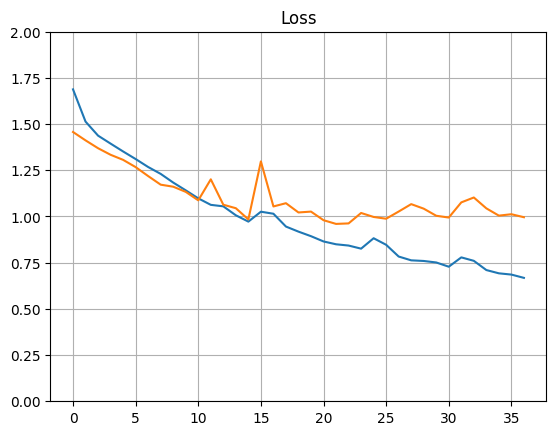

<Figure size 640x480 with 0 Axes>

In [ ]:
### Evaluation LSTM
plot_loss(history_sel_LSTM.history,maxy=2.0)

In [ ]:
model_sel_LSTM_b = load_model(MODEL_DIR+'/model_sel_LSTM.keras')
pred_sel_LSTM = model_sel_LSTM.predict(X_test)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


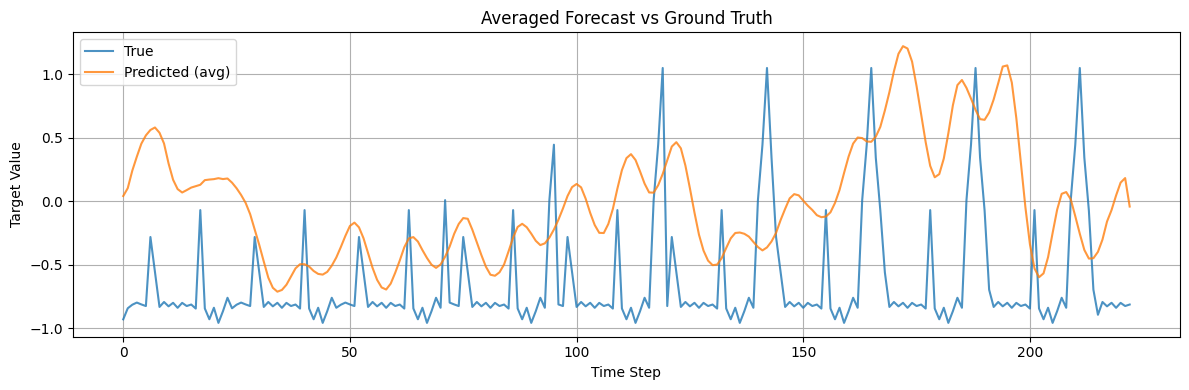

In [ ]:
plot_average_forecast(y_test[:100], pred_sel_LSTM[0:100])

In [267]:
#  Build S2S Model

def build_S2S(encoder_input, decoder_input, units=64, dropout = 0.2, lr = 1e-4):
    #Encoder
    encoder_input = layers.Input(shape=encoder_input.shape[1:], name='EncoderInput')
    encoder_lstm = layers.LSTM(units, return_state=True, name='Encoder')
    #Decoder
    decoder_input = layers.Input(shape=decoder_input.shape[1:], name='DecoderInput')
    decoder_lstm = layers.LSTM(units, return_sequences=True, return_state=True, name='Decoder')
    decoder_dropout = layers.Dropout(rate=dropout)
    decoder_dense = layers.Dense(1, name='DecoderDense')

    #IO
    _, state_h, state_c = encoder_lstm(encoder_input)
    decoder_output, _, _ = decoder_lstm(decoder_input, initial_state=[state_h, state_c])
    droped_output = decoder_dropout(decoder_output)
    final_output = decoder_dense(droped_output)

    #Model
    model = Model(inputs=[encoder_input, decoder_input], outputs=final_output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

In [218]:
delete_model('model_sel_S2S', 'history_sel_S2S')

decoder_input = np.zeros_like(y_model_sel)
decoder_input[:, 1:, :] = y_model_sel[:, :-1, :]

model_sel_S2S = build_S2S(X_model_sel, decoder_input)
model_sel_S2S.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ EncoderInput        │ (None, 168, 11)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderInput        │ (None, 24, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder (LSTM)      │ [(None, 64),      │     19,456 │ EncoderInput[0][… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder (LSTM)      │ [(None, 24, 64),  │     16,896 │ DecoderInput[0][… │
│                     │ (None, 64),       │            │ Encoder[0][1],    │
│                     │ (None, 64)]       │            │ Encoder[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 64)    │          0 │ Decoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderDense        │ (None, 24, 1)     │         65 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,417 (142.25 KB)

 Trainable params: 36,417 (142.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train S2S Model

history_sel_S2S = model_sel_S2S.fit(
    [X_model_sel, decoder_input],  
    y_model_sel,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks = [early_stop(10), check_point('model_sel_S2S')],
    shuffle=False
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.0999 - mae: 1.1544 - val_loss: 1.4625 - val_mae: 0.9945
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.7924 - mae: 1.0809 - val_loss: 1.4113 - val_mae: 0.9934
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 1.5881 - mae: 1.0324 - val_loss: 1.3679 - val_mae: 0.9855
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.4734 - mae: 1.0021 - val_loss: 1.3167 - val_mae: 0.9652
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.4118 - mae: 0.9785 - val_loss: 1.2696 - val_mae: 0.9436
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.3666 - mae: 0.9605 - val_loss: 1.2287 - val_mae: 0.9246
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.3210 - mae: 0.9412 - val_loss: 1.1917 - val_mae: 0.9072
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.2825 - mae: 0.9249 - val_loss: 1.1576 - val_mae: 0.8915
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - lo

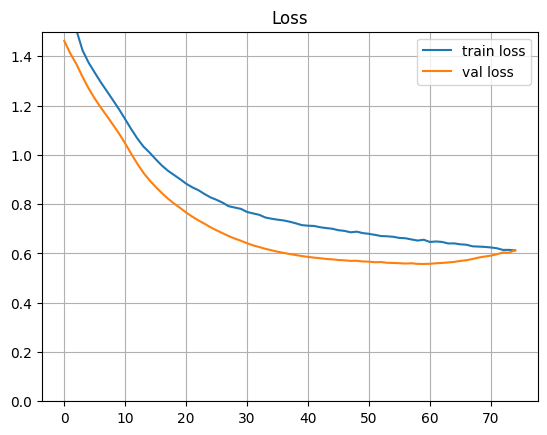

<Figure size 640x480 with 0 Axes>

In [220]:
# Evaluate S2S Model
plot_loss(history_sel_S2S.history, maxy=1.5)

In [221]:
model_sel_S2S_b = load_model(MODEL_DIR + '/model_sel_S2S_best.keras')

In [222]:
decoder_input_test = np.zeros_like(y_test)
decoder_input_test[:, 1:, :] = y_test[:, :-1, :]
decoder_input_test[:, 0, :] = 0  # assume zeroed start


In [223]:

pred_sel_S2S = model_sel_S2S_b.predict([X_test, decoder_input_test])

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


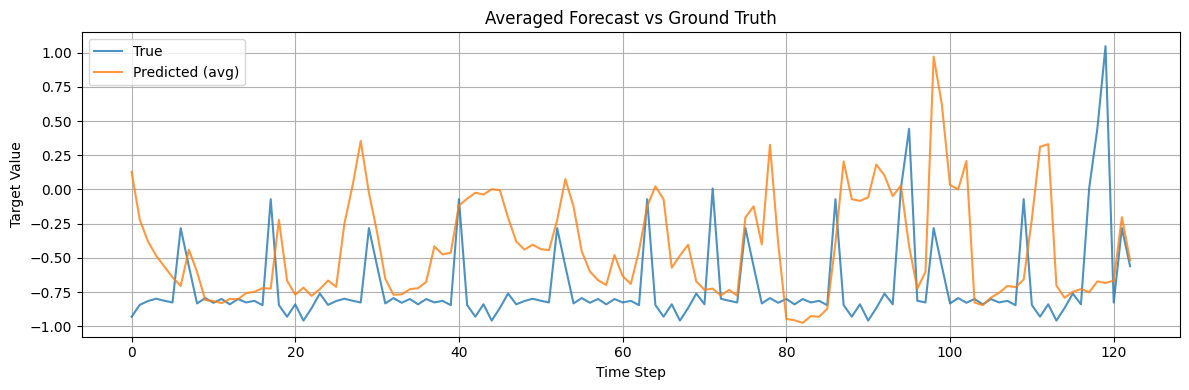

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2572 - mae: 0.3688


[0.26608845591545105, 0.3670646846294403]

In [224]:
plot_average_forecast(y_test[:100], pred_sel_S2S[:100])
model_sel_S2S_b.evaluate([X_test, decoder_input_test], y_test)

## 3. Hyperparameter Tuning
The model selected is S2S for significantly better performance. 

### Hyperparameters
Hyperparameters to be tuned:
- `learning_rate`: `[5e-5, 1e-4, 3e-4]`
- `units`: `[32, 64, 128]`
- `dropout`: `[0.2, 0.3]`
- `batch_size`: `[32, 64]`

### Train
Tune hyperparameters on `hparam_tuning` subset with `validation_split = 0.2`. 

When tuning, reduce EarlyStop patience to 10, limit 50 epochs. 

### Save Models Logs
- Save models in `model/tune`
 -Save logs in `log/hparam`

In [281]:
### Hyperparameter Tuning
# delete hyperparameter tuning logs
%rm -rf ./hparam/*

In [282]:
# Tuning hyperparameters 
#learning_rate: [5e-5, 1e-4, 3e-4]
#units: [32, 64, 128]
#dropout: [0.2, 0.3]
#batch_size: [32, 64]

HP_LR = hp.HParam('learning_rate', hp.Discrete([5e-5, 1e-4, 3e-4]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.2, 0.3]))
HP_UNITS = hp.HParam('units', hp.Discrete([32, 64, 128]))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([32, 64]))

METRIC_LOSS = 'loss'
METRIC_GAP = 'gap'

# initiate tfboard log
with tf.summary.create_file_writer('hparam/log/').as_default():
    hp.hparams_config(
        hparams=[HP_LR, HP_DROPOUT, HP_UNITS, HP_BATCH_SIZE],
        metrics=[
            hp.Metric(METRIC_LOSS, display_name='MSE'), 
            hp.Metric(METRIC_GAP, display_name='Loss Gap')
        ],
    )


In [283]:

decoder_input_tune = np.zeros_like(y_tune)
decoder_input_tune[:, 1:, :] = y_tune[:, :-1, :]


In [284]:
def train_test_model(hparams, log_dir, id):
    model = build_S2S(
        X_tune,
        decoder_input_tune, 
        units=hparams[HP_UNITS], 
        dropout=hparams[HP_DROPOUT], 
        lr=hparams[HP_LR]
    )
    history = model.fit(
        [X_tune, decoder_input_tune], 
        y_tune, 
        validation_split=0.2, 
        epochs=100, 
        batch_size=hparams[HP_BATCH_SIZE], 
        verbose=0, 
        callbacks=[
            check_point(f'hparam_S2S_{id}', hparam=True),
            early_stop(10),
            TensorBoard(log_dir),
            hp.KerasCallback(log_dir, hparams)
        ]
    )
    train_loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']
    best_epoch = np.argmin(val_loss_history)
    min_train_loss = train_loss_history[best_epoch]
    min_val_loss = val_loss_history[best_epoch]

    loss_gap = abs(min_train_loss - min_val_loss)
    with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.scalar(METRIC_LOSS, min_val_loss, step=1)
        tf.summary.scalar(METRIC_GAP, loss_gap, step=1)

    # delete the model to free up VRAM
    delete_model('model', 'history')
    return train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap

In [285]:
session_num = 0
results = []
# iterate among all hyperparameters to be tuned
for lr in HP_LR.domain.values:
    for dropout in HP_DROPOUT.domain.values:
        for units in HP_UNITS.domain.values:
            for batch in HP_BATCH_SIZE.domain.values:
                hparams = {
                    HP_LR: lr,
                    HP_DROPOUT: dropout,
                    HP_UNITS: units,
                    HP_BATCH_SIZE: batch
                }

                run_name = f"run-{session_num}"
                print(f"--- Starting trial: {run_name}")
                print({h.name: hparams[h] for h in hparams})
                log_dir = f'hparam/log/{run_name}'
                train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap = train_test_model(hparams, log_dir, session_num)
                print(f'best loss {min_train_loss, min_val_loss} found at epoch {best_epoch}, with gap {loss_gap}')
                results.append((hparams, train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap))
                session_num += 1


--- Starting trial: run-0
{'learning_rate': 5e-05, 'dropout': 0.2, 'units': 32, 'batch_size': 32}
best loss (0.47294366359710693, 0.3776322603225708) found at epoch 86, with gap 0.09531140327453613
--- Starting trial: run-1
{'learning_rate': 5e-05, 'dropout': 0.2, 'units': 32, 'batch_size': 64}
best loss (0.5198771357536316, 0.4214458167552948) found at epoch 91, with gap 0.09843131899833679
--- Starting trial: run-2
{'learning_rate': 5e-05, 'dropout': 0.2, 'units': 64, 'batch_size': 32}
best loss (0.5417749285697937, 0.4458346962928772) found at epoch 20, with gap 0.0959402322769165
--- Starting trial: run-3
{'learning_rate': 5e-05, 'dropout': 0.2, 'units': 64, 'batch_size': 64}
best loss (0.49577078223228455, 0.4139759838581085) found at epoch 52, with gap 0.08179479837417603
--- Starting trial: run-4
{'learning_rate': 5e-05, 'dropout': 0.2, 'units': 128, 'batch_size': 32}
best loss (0.5511752367019653, 0.4429388642311096) found at epoch 14, with gap 0.10823637247085571
--- Starting 

In [ ]:
%tensorboard --logdir hparam/log

In [333]:
# display hyperparameter tuning result
rows = []
train_loss_tune = []
val_loss_tune = []
for hparams, train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap in results:
    row = {h.name: hparams[h] for h in hparams}
    row['best_epoch'] = best_epoch
    row['min_train_loss'] = min_train_loss
    row['min_val_loss'] = min_val_loss
    row['loss_gap'] = loss_gap
    rows.append(row)
    train_loss_tune.append(train_loss_history)
    val_loss_tune.append(val_loss_history)
    # print(len(train_loss_history))
df = pd.DataFrame(rows).sort_values(by='min_val_loss')
print(len(train_loss_tune))
print(df[:10])

36
    learning_rate  dropout  units  batch_size  best_epoch  min_train_loss  \
28        0.00030      0.2    128          32           8        0.427663   
32        0.00030      0.3     64          32          19        0.428034   
25        0.00030      0.2     32          64          49        0.428913   
35        0.00030      0.3    128          64          17        0.424985   
30        0.00030      0.3     32          32          22        0.455343   
22        0.00010      0.3    128          32          18        0.451588   
0         0.00005      0.2     32          32          86        0.472944   
27        0.00030      0.2     64          64          22        0.434731   
16        0.00010      0.2    128          32          14        0.477360   
31        0.00030      0.3     32          64          30        0.465122   

    min_val_loss  loss_gap  
28      0.361467  0.066196  
32      0.367943  0.060091  
25      0.369649  0.059264  
35      0.370102  0.054883  
30  

In [334]:
df_filtered = df[df['best_epoch'] > 20]
best_param = df_filtered.loc[df_filtered['min_val_loss'].idxmin()]
best_param

learning_rate      0.000300
dropout            0.200000
units             32.000000
batch_size        64.000000
best_epoch        49.000000
min_train_loss     0.428913
min_val_loss       0.369649
loss_gap           0.059264
Name: 25, dtype: float64

In [335]:
# save best hyperparameters

BEST_LR = best_param['learning_rate']
BEST_DROPOUT = best_param['dropout']
BEST_UNITS = int(best_param['units'])
BEST_BATCH_SIZE = int(best_param['batch_size'])
BEST_NAME = best_param.name
# use tuned best hyperparameters if didn't run tuning

# BEST_LR = 3e-4
# BEST_DROPOUT = 0.2
# BEST_UNITS = 32
# BEST_BATCH_SIZE = 64
# BEST_NAME = 25

In [343]:
best_model = load_model(f'hparam/model/hparam_S2S_{BEST_NAME}.keras')

In [344]:
best_history = pd.DataFrame({
        'loss': train_loss_tune[BEST_NAME],
        'val_loss': val_loss_tune[BEST_NAME]
    })

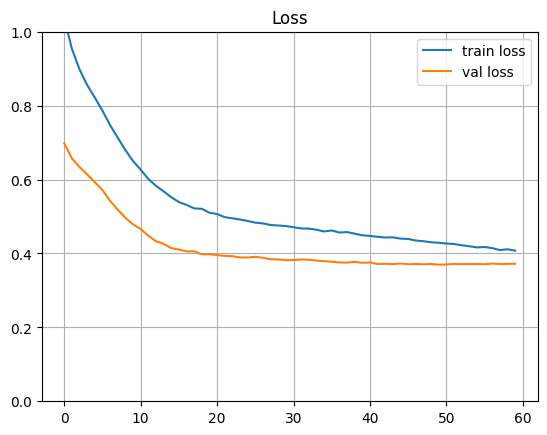

<Figure size 640x480 with 0 Axes>

In [345]:
plot_loss(best_history, maxy=1)

In [346]:
best_y_pred = best_model.predict([X_test, decoder_input_test])
best_model.evaluate([X_test, decoder_input_test], y_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4032 - mae: 0.5072


[0.476224809885025, 0.5425533056259155]

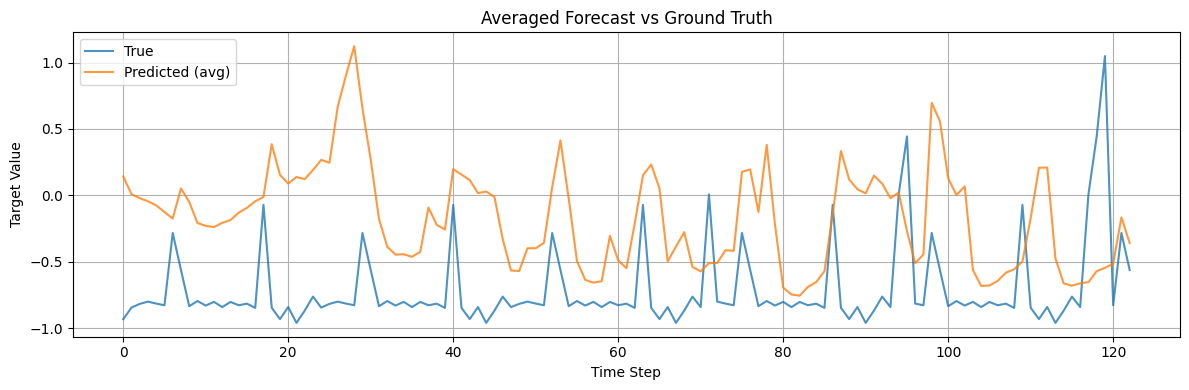

In [347]:
plot_average_forecast(y_test[:100], best_y_pred[:100])

## 4. Model Train and Evaluation

### Train Tuned Model
Train model on `train` subset with `validation_split = 0.2`. 

### Save Model
Save model in `model`. 

### Evaluate Model
Use `test` subset to evaluate model with metrics $\mathrm{RMSE}$ and $\mathrm{MAE}$. 

### Visualization
Plots to be visualized
- Actual vs Predicted 
- Loss over Epochs

### Analyze Model Performance


In [348]:
### Train Tuned Model

train_decoder = np.zeros_like(y_train)
train_decoder[:, 1:, :] = y_train[:, :-1, :]


In [349]:
delete_model('final_model', 'final_history')
final_model = build_S2S(X_train, train_decoder, units = BEST_UNITS, dropout=BEST_DROPOUT, lr=BEST_LR)
final_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ EncoderInput        │ (None, 168, 11)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderInput        │ (None, 24, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder (LSTM)      │ [(None, 32),      │      5,632 │ EncoderInput[0][… │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder (LSTM)      │ [(None, 24, 32),  │      4,352 │ DecoderInput[0][… │
│                     │ (None, 32),       │            │ Encoder[0][1],    │
│                     │ (None, 32)]       │            │ Encoder[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 32)    │          0 │ Decoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderDense        │ (None, 24, 1)     │         33 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,017 (39.13 KB)

 Trainable params: 10,017 (39.13 KB)

 Non-trainable params: 0 (0.00 B)

In [350]:
final_history = final_model.fit(
    [X_train, train_decoder], 
    y_train, 
    validation_split=0.2, 
    epochs=100, 
    batch_size=BEST_BATCH_SIZE, 
    callbacks=[
        check_point(f'final_S2S'),
        early_stop(10),
    ]
)

Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.8945 - mae: 0.7427 - val_loss: 0.5258 - val_mae: 0.5527
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.6026 - mae: 0.5733 - val_loss: 0.4528 - val_mae: 0.4933
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.5279 - mae: 0.5238 - val_loss: 0.4394 - val_mae: 0.4795
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.5013 - mae: 0.5045 - val_loss: 0.4325 - val_mae: 0.4741
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.4859 - mae: 0.4939 - val_loss: 0.4261 - val_mae: 0.4660
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.4723 - mae: 0.4854 - val_loss: 0.4203 - val_mae: 0.4622
Epoch 7/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.4636 - mae: 0.4796 - val_loss: 0.4147 - val_mae: 0.4584
Epoch 8/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.4553 - mae: 0.4753 - val_loss: 0.4041 - val_mae: 0.4501
Epoch 9/100
217/217 ━━━━━━━━━━━━━━━━━━━━

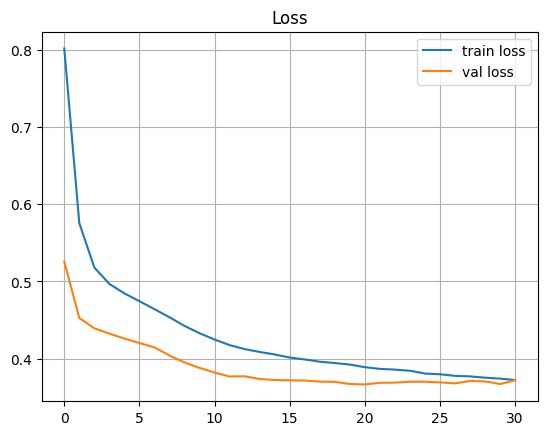

<Figure size 640x480 with 0 Axes>

In [351]:
plot_loss(final_history.history)

In [352]:
final_model = load_model('model/final_S2S.keras')

In [353]:
### Evaluate Model
final_model.evaluate([X_test, decoder_input_test], y_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1981 - mae: 0.3207


[0.19966398179531097, 0.31700289249420166]

In [354]:
final_pred = final_model.predict([X_test, decoder_input_test])

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


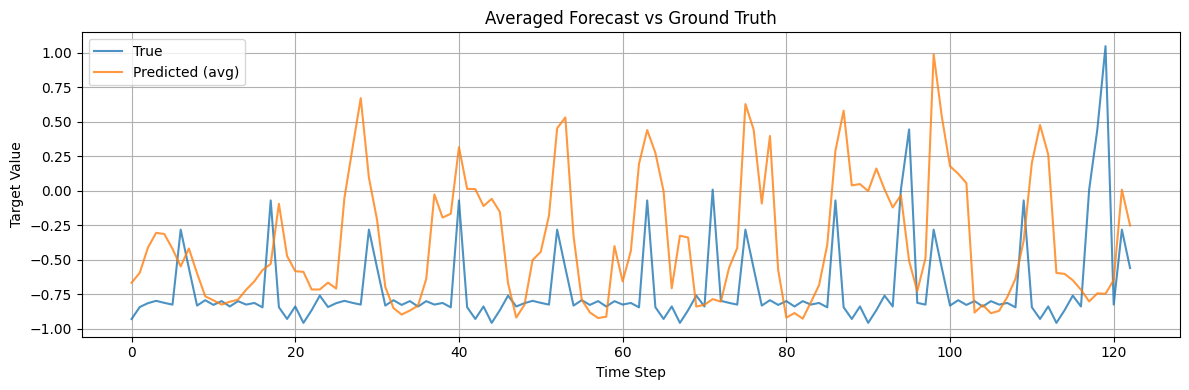

In [355]:
plot_average_forecast(y_test[:100], final_pred[:100])

In [124]:
### Visualization

In [125]:
### Analyze Model Performance


## 5. Forecaste to Energy Optimization

### Use `test1` and `test2` subset, take one day/week ahead, predict the `global_active_power` of the subset. 

### Merics
RMSE, MAE

### Visualize Result
Predicted vs Actual
